## CS109b: Astronomy
### Notebook 1: ATLAS Data



In [ ]:
#!pip install astroalign

In [1]:
%matplotlib inline
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import math
from PIL import Image

import collections

from collections import defaultdict
import scipy.spatial

import importlib
import glob

import astropy
from astropy.io import fits

In the data directory 'atlas-neo-images' there are twelve sets of files.  Each set includes an image file (*.fits.fz extension), a file of the sources found in that image (*.dph extension), and a file of the known asteroids that were identified in the image (*.kastx extension).

The ATLAS telescopes are equipped with wide-field science-grade digital cameras.  The field of view is square, subtending 5.5 degrees on a side.  The detectors are 10K x 10K pixels.  The images are stored in FITS (Flexible Image Transport System) format, the standard in the astronomical community.  Although the FITS standard is decades old, it is easily read and managed with the astropy library.

Let's find all the files and open one.

In [2]:
image_filenames=sorted(glob.glob('atlas-neo-images/*.fits.fz'))

In [3]:
image_filenames

['data\\02a57983o0195c.fits.fz',
 'data\\02a57983o0196c.fits.fz',
 'data\\02a57983o0201c.fits.fz',
 'data\\02a57983o0234c.fits.fz',
 'data\\02a57984o0100c.fits.fz',
 'data\\02a57984o0118c.fits.fz',
 'data\\02a57984o0126c.fits.fz',
 'data\\02a57984o0155c.fits.fz',
 'data\\02a58903o0107c.fits.fz',
 'data\\02a58903o0127c.fits.fz',
 'data\\02a58903o0142c.fits.fz',
 'data\\02a58903o0162c.fits.fz']

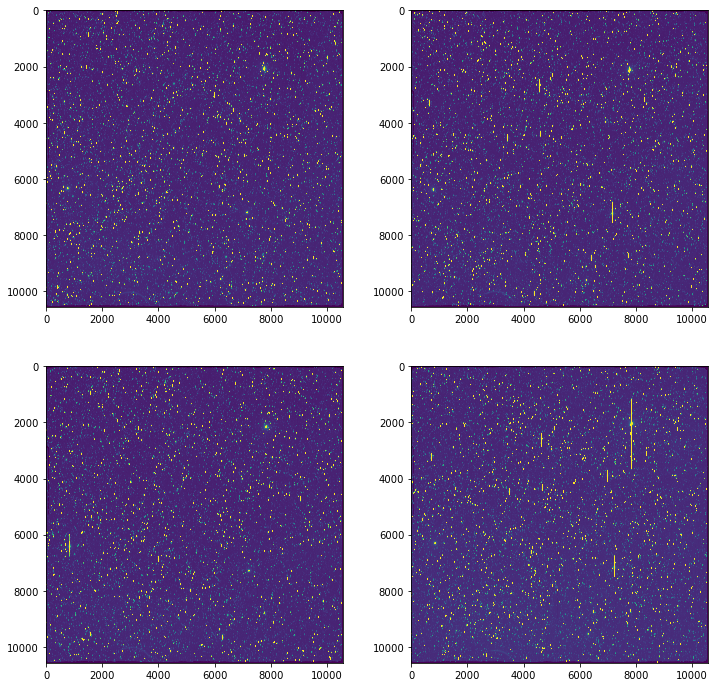

In [4]:
img_data = []   
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    img = fits.open(image_filenames[image_number])['image'].data
    img_data.append(img)
    ax.imshow(img, vmin=150, vmax=500)

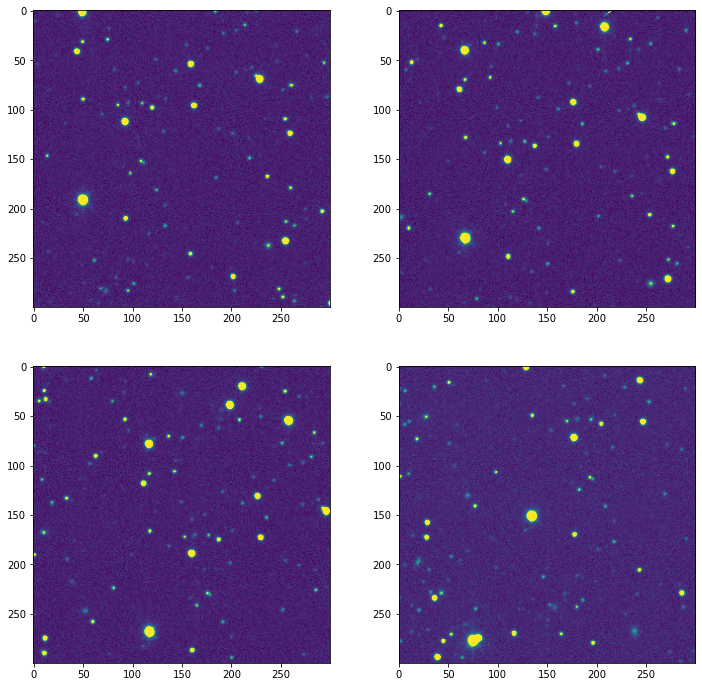

In [7]:
# check out a few closer crops
center_x = 3345
center_y = 5290
pad = 150
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    img = fits.open(image_filenames[image_number])['image'].data
    img_data.append(img)
    ax.imshow(img[center_x-pad:center_x+pad, center_y-pad:center_y+pad], vmin=150, vmax=500)

### Image Alignment using Astroalign
Based on the sample crops above, you can see that the stars do shift from image to image at a given pixel coordinate

In [8]:
import astroalign as aa

### Notes (Michael)

The above cells first look at one of the quads, then uses astroalign to align the images based on relatively stationary star points of its own choosing. 

registered, footprint = aa.register(img1, img2)

This line of code is aligning img1 to img2 and returning registered which is the aligned image for img1, aligned to img2. The footpoint is defined as " a boolean numpy array, True for masked pixels with no information" - I'm not using it currently. 

I aligned image 1 to image 2. Then image 3 to image 2. And finally image 4 to image 2. My intention here was to choose one of the middle images to have as our target thinking it would make the alignment easier. 

The resulting images are registered, img_data[1], registered2, and registered3, which correspond to the 4 images all aligned to the second image. 

Then, I calculated the average of the 4 images pixel-wise and plotted the 4 aligned images with the average subtracted. In theory, this should leave us with 4 (aligned) images of the same section of sky with only moving objects remaining. 

In [9]:
# define function to take 4 images and align them to second image
def align_quad(img1, img2, img3, img4):
    registered, footprint = aa.register(img1, img2)
    registered3, footprint = aa.register(img3, img2)
    registered4, footprint = aa.register(img4, img2)
    return [registered, img2, registered3, registered4]

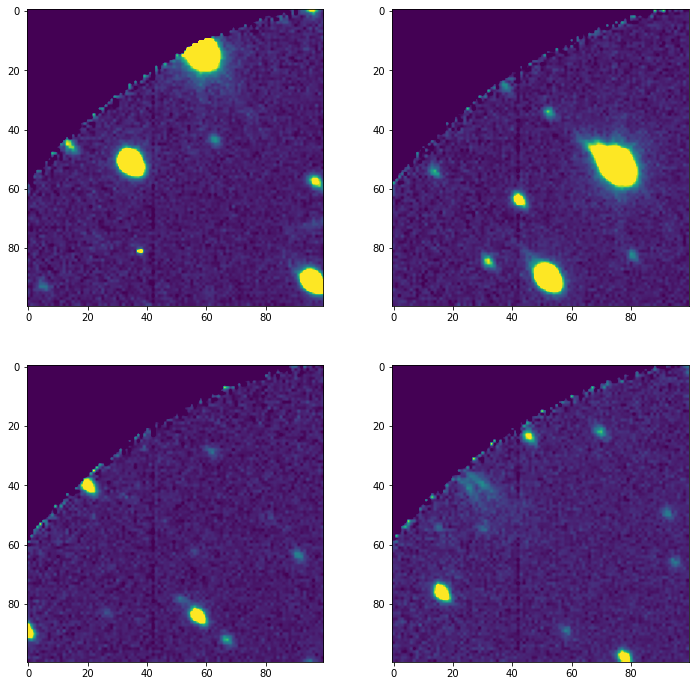

In [10]:
# try with next quad

img_data = []   
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    img = fits.open(image_filenames[image_number])['image'].data
    img_data.append(img)
    ax.imshow(img[50:150,50:150], vmin=150, vmax=500)

In [11]:
aligned_imgs = align_quad(img_data[0], img_data[1], img_data[2], img_data[3])

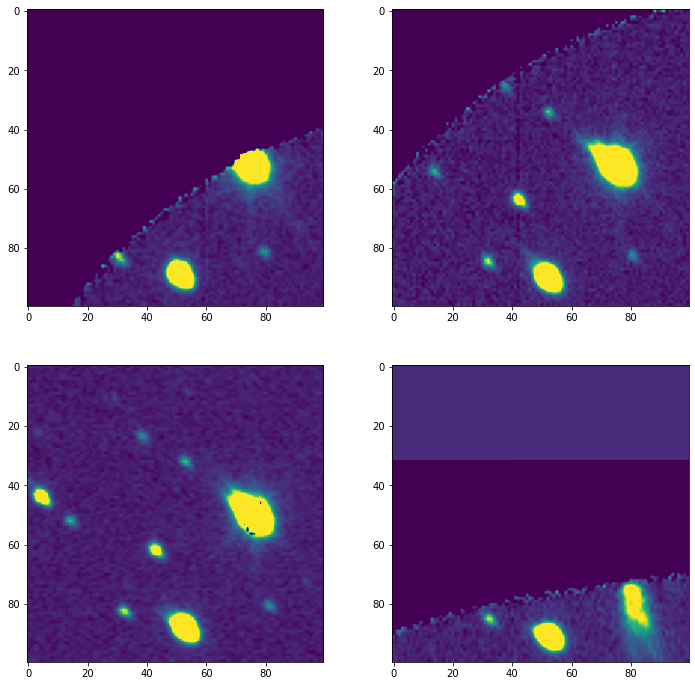

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    #im = Image.fromarray(aligned_imgs[image_number])
    #im.save(f'{image_filenames[image_number]}-aligned.jpg')
    ax.imshow(aligned_imgs[image_number][50:150,50:150], vmin=150, vmax=500)

In [13]:
avg = np.mean(aligned_imgs, axis=0)

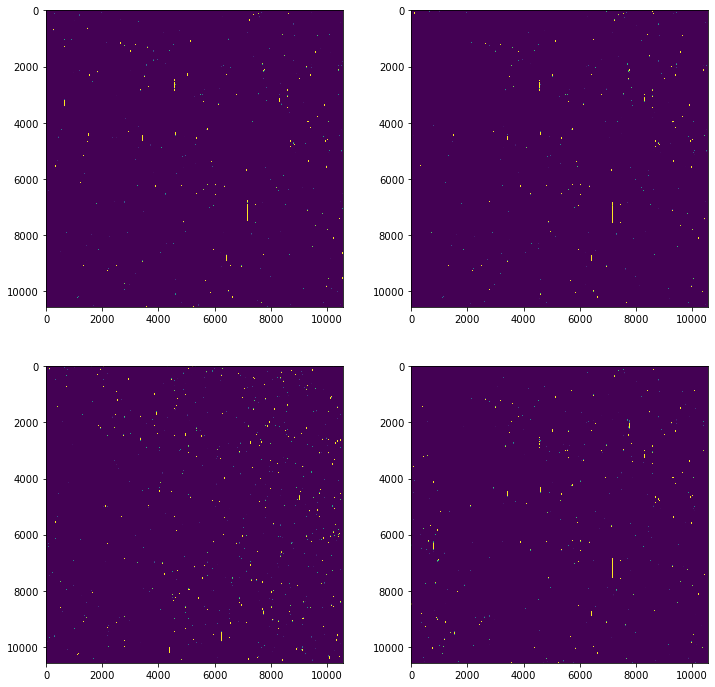

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

for ax, image_number in zip(axs.ravel(), range(4)):
    new_image = aligned_imgs[image_number]-avg
    ax.imshow(new_image, vmin=150, vmax=500)

In [15]:
plt.imsave('data/test.jpg', new_image, vmin=150, vmax=500)

### Looking at dhp files

The dhp files are identified objects corresponding to each image. Through the 'neighbors' process defined in the lecture notebook, we can use this data to remove stationary points (stars, galaxies, etc.). This section of code does this for the first set of 4 images. 

In [21]:
dph_filenames=sorted(glob.glob('atlas-neo-images/*.dph'))

In [22]:
dph_filenames

['data\\02a57983o0195c.dph',
 'data\\02a57983o0196c.dph',
 'data\\02a57983o0201c.dph',
 'data\\02a57983o0234c.dph',
 'data\\02a57984o0100c.dph',
 'data\\02a57984o0118c.dph',
 'data\\02a57984o0126c.dph',
 'data\\02a57984o0155c.dph',
 'data\\02a58903o0107c.dph',
 'data\\02a58903o0127c.dph',
 'data\\02a58903o0142c.dph',
 'data\\02a58903o0162c.dph']

In [23]:
dph_filenames[0], image_filenames[0]

('data\\02a57983o0195c.dph', 'data\\02a57983o0195c.fits.fz')

In [24]:
ras, decs = [], []

In [25]:
# i want to keep track of which image each set of data came from

names =  ['RA', 'Dec', 'm', 'idx', 'Type', 'xtsk', 'ytsk', 'minst', 'dminst', 'sky', 'major', 
          'minor', 'phi', 'probgal', 'apmag', 'dapmag', 'apsky', 'ap-fit']

df = pd.read_csv(dph_filenames[8], sep='\s+', names=names, skiprows=1)
df['quad'] = 1
df2 = pd.read_csv(dph_filenames[9], sep='\s+', names=names, skiprows=1)
df2['quad'] = 2
df3 = pd.read_csv(dph_filenames[10], sep='\s+', names=names, skiprows=1)
df3['quad'] = 3
df4 = pd.read_csv(dph_filenames[11], sep='\s+', names=names, skiprows=1)
df4['quad'] = 4

In [26]:
# add the dataframes
# this now represents all the objects that were detected in this quad. 
# with a "quad" column to identify which image the object is in

df_all = pd.concat([df, df2, df3, df4], ignore_index=True)

In [27]:
df_all.head()

,RA,Dec,m,idx,Type,xtsk,ytsk,minst,dminst,sky,major,minor,phi,probgal,apmag,dapmag,apsky,ap-fit,quad
0,128.39271,16.61259,13.462,2,1,714.81,5279.19,-12.202,0.011,193.76,2.682,2.322,-52.04,0.243,-12.475,0.004,200.70,-0.273,1
1,129.76456,16.62735,13.782,3,1,3273.50,5279.49,-11.884,0.008,190.36,2.535,2.400,-45.39,5.470,-12.147,0.005,201.81,-0.264,1
2,130.78474,17.99611,13.272,4,1,5172.41,2640.22,-12.393,0.006,179.67,2.543,2.435,-55.16,13.500,-12.644,0.003,205.67,-0.251,1
3,128.13046,15.25144,13.738,6,1,171.28,7921.91,-11.949,0.023,155.69,2.832,2.245,-49.92,-15.000,-12.187,0.004,197.82,-0.239,1
4,131.46394,17.99570,13.078,7,1,6423.17,2641.70,-12.593,0.006,173.65,2.558,2.450,-57.36,-15.000,-12.843,0.003,205.41,-0.250,1


In [28]:
ras, decs = [], []
files= glob.glob('atlas-neo-images/02a58903o*.dph')
for filename in sorted(files):
    with open(filename) as f:
        for line in f:
            if line.lstrip().startswith('#'):
                continue
            else:
                ra, dec = line.strip().split()[0:2]
                raDeg = float(ra)
                decDeg = float(dec)
                ras.append(raDeg)
                decs.append(decDeg)

ras=np.array(ras)
decs=np.array(decs)

In [29]:
def convert_points(ra, dec):
    d2r = np.pi/180.
    x = np.cos(ra*d2r) * np.cos(dec*d2r)
    y = np.sin(ra*d2r) * np.cos(dec*d2r)
    z = np.sin(dec*d2r)
    points = np.array([x, y, z]).T
    return points

In [30]:
from scipy import spatial

pts=convert_points(ras, decs)
tree = spatial.cKDTree(pts)

In [31]:
# ive increased the search radius from lecture to reduce the number of objects a bit more

sr=(10/3600.)*np.pi/180.

idx = tree.query_ball_tree(tree, sr)

singles = [i for (i, k) in enumerate(idx) if len(k)==1]
matches = [i for (i, k) in enumerate(idx) if len(k)>1]

In [32]:
all_singles = df_all.iloc[singles]

In [33]:
all_singles.head()

,RA,Dec,m,idx,Type,xtsk,ytsk,minst,dminst,sky,major,minor,phi,probgal,apmag,dapmag,apsky,ap-fit,quad
46,128.07503,16.57647,12.357,72,1,116.44,5340.19,-13.365,0.020,125.42,2.744,2.304,-52.68,-3.49,99.999,0.0,0.0,0.0,1
120,132.10346,16.55311,12.261,182,1,7610.07,5432.50,-13.414,0.011,135.32,2.625,2.580,-53.37,1.60,99.999,0.0,0.0,0.0,1
281,130.90670,17.84315,12.407,427,1,5396.19,2937.57,-13.255,0.008,163.39,2.532,2.442,-54.51,-15.70,99.999,0.0,0.0,0.0,1
284,128.45298,17.81697,13.618,431,1,858.07,2940.40,-12.057,0.011,230.81,2.753,2.389,-55.01,17.40,99.999,0.0,0.0,0.0,1
498,129.73752,16.33102,12.445,783,1,3218.41,5852.46,-13.224,0.009,160.43,2.549,2.397,-44.31,8.62,99.999,0.0,0.0,0.0,1


In [34]:
singles_1 = all_singles[all_singles['quad'] == 1]
singles_2 = all_singles[all_singles['quad'] == 2]
singles_3 = all_singles[all_singles['quad'] == 3]
singles_4 = all_singles[all_singles['quad'] == 4]

In [35]:
singles_1

,RA,Dec,m,idx,Type,xtsk,ytsk,minst,dminst,sky,major,minor,phi,probgal,apmag,dapmag,apsky,ap-fit,quad
46,128.07503,16.57647,12.357,72,1,116.44,5340.19,-13.365,0.020,125.42,2.744,2.304,-52.68,-3.490000e+00,99.999,0.000,0.0,0.0,1
120,132.10346,16.55311,12.261,182,1,7610.07,5432.50,-13.414,0.011,135.32,2.625,2.580,-53.37,1.600000e+00,99.999,0.000,0.0,0.0,1
281,130.90670,17.84315,12.407,427,1,5396.19,2937.57,-13.255,0.008,163.39,2.532,2.442,-54.51,-1.570000e+01,99.999,0.000,0.0,0.0,1
284,128.45298,17.81697,13.618,431,1,858.07,2940.40,-12.057,0.011,230.81,2.753,2.389,-55.01,1.740000e+01,99.999,0.000,0.0,0.0,1
498,129.73752,16.33102,12.445,783,1,3218.41,5852.46,-13.224,0.009,160.43,2.549,2.397,-44.31,8.620000e+00,99.999,0.000,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98666,133.10116,19.30429,19.660,104651,7,9447.35,52.10,-6.036,0.310,196.16,2.898,2.360,-56.97,-4.090000e+11,99.999,0.000,0.0,0.0,1
98667,133.63146,14.57900,17.192,104653,7,10528.75,9266.56,-8.534,0.394,107.67,3.365,2.906,-51.82,-1.300000e+01,99.999,99.999,0.0,0.0,1
98668,133.65421,15.74584,17.149,104656,7,10532.16,6983.04,-8.545,0.199,61.24,3.043,2.787,-57.27,-4.810000e+00,99.999,99.999,0.0,0.0,1
98669,133.64864,15.68191,19.897,104657,7,10523.49,7107.74,-5.798,0.066,217.69,3.054,2.794,-56.98,-2.510000e+06,99.999,0.000,0.0,0.0,1


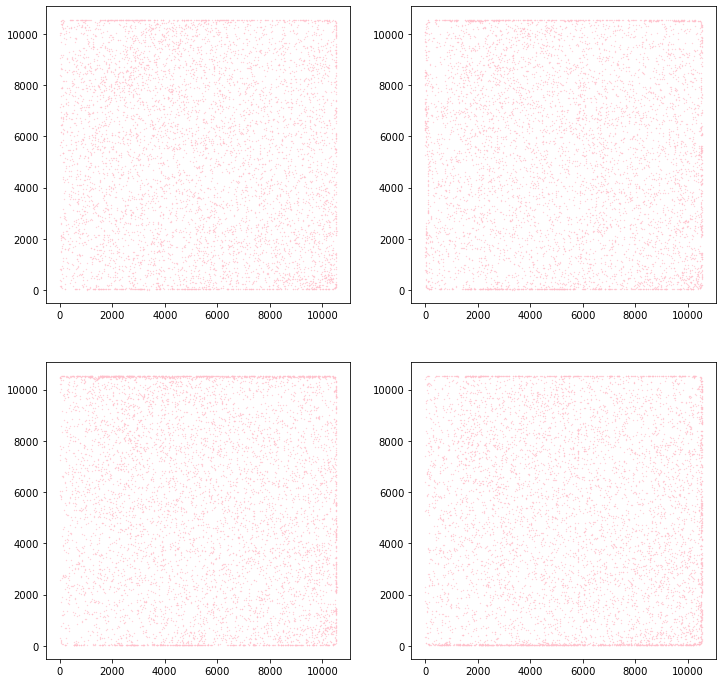

In [36]:
# these are the pixel coordinates for the single objects found in each image in the quad

fig, axs = plt.subplots(2, 2, figsize=(12,12))
si = [singles_1, singles_2, singles_3, singles_4]

for ax, image_number in zip(axs.ravel(), range(4)):
    #img = fits.open(image_filenames[image_number])['image'].data
    #ax.imshow(img, vmin=150, vmax=500)
    ax.scatter(si[image_number].xtsk, si[image_number].ytsk, s=0.1, c='pink')

#plt.scatter(singles_1.xtsk, singles_1.ytsk, s=0.1)

In [37]:
all_singles.head()

,RA,Dec,m,idx,Type,xtsk,ytsk,minst,dminst,sky,major,minor,phi,probgal,apmag,dapmag,apsky,ap-fit,quad
46,128.07503,16.57647,12.357,72,1,116.44,5340.19,-13.365,0.020,125.42,2.744,2.304,-52.68,-3.49,99.999,0.0,0.0,0.0,1
120,132.10346,16.55311,12.261,182,1,7610.07,5432.50,-13.414,0.011,135.32,2.625,2.580,-53.37,1.60,99.999,0.0,0.0,0.0,1
281,130.90670,17.84315,12.407,427,1,5396.19,2937.57,-13.255,0.008,163.39,2.532,2.442,-54.51,-15.70,99.999,0.0,0.0,0.0,1
284,128.45298,17.81697,13.618,431,1,858.07,2940.40,-12.057,0.011,230.81,2.753,2.389,-55.01,17.40,99.999,0.0,0.0,0.0,1
498,129.73752,16.33102,12.445,783,1,3218.41,5852.46,-13.224,0.009,160.43,2.549,2.397,-44.31,8.62,99.999,0.0,0.0,0.0,1


In [38]:
df.head()

,RA,Dec,m,idx,Type,xtsk,ytsk,minst,dminst,sky,major,minor,phi,probgal,apmag,dapmag,apsky,ap-fit,quad
0,128.39271,16.61259,13.462,2,1,714.81,5279.19,-12.202,0.011,193.76,2.682,2.322,-52.04,0.243,-12.475,0.004,200.70,-0.273,1
1,129.76456,16.62735,13.782,3,1,3273.50,5279.49,-11.884,0.008,190.36,2.535,2.400,-45.39,5.470,-12.147,0.005,201.81,-0.264,1
2,130.78474,17.99611,13.272,4,1,5172.41,2640.22,-12.393,0.006,179.67,2.543,2.435,-55.16,13.500,-12.644,0.003,205.67,-0.251,1
3,128.13046,15.25144,13.738,6,1,171.28,7921.91,-11.949,0.023,155.69,2.832,2.245,-49.92,-15.000,-12.187,0.004,197.82,-0.239,1
4,131.46394,17.99570,13.078,7,1,6423.17,2641.70,-12.593,0.006,173.65,2.558,2.450,-57.36,-15.000,-12.843,0.003,205.41,-0.250,1


### What are these .kastx files?



In [39]:
kastx_filenames=sorted(glob.glob('atlas-neo-images/*.kastx'))

kastx_filenames

['data\\02a57983o0195c.kastx',
 'data\\02a57983o0196c.kastx',
 'data\\02a57983o0201c.kastx',
 'data\\02a57983o0234c.kastx',
 'data\\02a57984o0100c.kastx',
 'data\\02a57984o0118c.kastx',
 'data\\02a57984o0126c.kastx',
 'data\\02a57984o0155c.kastx',
 'data\\02a58903o0107c.kastx',
 'data\\02a58903o0127c.kastx',
 'data\\02a58903o0142c.kastx',
 'data\\02a58903o0162c.kastx']

In [40]:
with open('atlas-neo-images\\02a57983o0195c.kastx') as f:
    print(f.readlines())

['DESIG          Q_AU      E    I_DEG            OBS EPOCH_MJD_UTC OBSCODE    RA_DEG   DEC_DEG     V  DRA_DT DDEC_DT DELTA_AU     R_AU PHASE_DEG     TPX     TPY\n', '142040     1.092689 0.3445  28.2435 02a57983o0195c 57983.332525     T05 258.93504  32.30812 18.14 -0.0090 -0.1359   0.7900   1.3908  45.7335  1391.1  4788.2\n']


In [41]:

labels1 = pd.read_csv(kastx_filenames[8], sep='\s+')
labels2 = pd.read_csv(kastx_filenames[9], sep='\s+')
labels3 = pd.read_csv(kastx_filenames[10], sep='\s+')
labels4 = pd.read_csv(kastx_filenames[11], sep='\s+')

In [42]:
labels1

,DESIG,Q_AU,E,I_DEG,OBS,EPOCH_MJD_UTC,OBSCODE,RA_DEG,DEC_DEG,V,DRA_DT,DDEC_DT,DELTA_AU,R_AU,PHASE_DEG,TPX,TPY
0,173,2.170657,0.2088,14.1959,02a58903o0107c,58903.257413,T05,133.07180,14.13003,12.09,-0.1686,0.1253,2.0147,2.9488,7.6846,9476.2,10150.5
1,689,1.785659,0.2291,5.7403,02a58903o0107c,58903.257413,T05,128.53683,14.08132,16.15,-0.1808,0.0916,1.7500,2.6653,9.9855,893.2,10223.5
2,860,2.499395,0.1065,13.2972,02a58903o0107c,58903.257413,T05,129.87745,15.96081,14.98,-0.1879,-0.0013,2.1682,3.0837,8.3247,3472.7,6570.9
3,1274,1.978333,0.1127,4.3965,02a58903o0107c,58903.257413,T05,131.32180,18.96811,14.56,-0.2181,0.0103,1.1914,2.1247,11.8602,6164.2,746.7
4,1503,2.351831,0.1043,12.3672,02a58903o0107c,58903.257413,T05,131.95153,16.70279,13.79,-0.2093,-0.0438,1.4187,2.3529,10.2452,7326.9,5143.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2013CY125,2.112196,0.0971,2.4935,02a58903o0107c,58903.257413,T05,132.41817,18.05581,20.23,-0.1897,0.0770,1.2313,2.1691,11.0860,8184.6,2515.5
531,2014QX24,2.400406,0.0276,6.3135,02a58903o0107c,58903.257413,T05,131.20242,15.65716,20.09,-0.1970,0.0153,1.5107,2.4413,10.0540,5936.8,7168.3
532,2015BF91,2.657789,0.1128,10.1275,02a58903o0107c,58903.257413,T05,132.05664,15.93174,20.08,-0.1488,0.1089,1.8101,2.7402,8.6979,7527.9,6635.9
533,2015XW379,17.316403,0.3778,11.8992,02a58903o0107c,58903.257413,T05,132.83198,14.91429,20.09,-0.0337,0.0130,19.3946,20.3036,1.1285,8998.9,8611.4


In [43]:
quad1_labels = pd.concat([labels1, labels2, labels3, labels4], ignore_index=True)

In [44]:
quad1_labels

,DESIG,Q_AU,E,I_DEG,OBS,EPOCH_MJD_UTC,OBSCODE,RA_DEG,DEC_DEG,V,DRA_DT,DDEC_DT,DELTA_AU,R_AU,PHASE_DEG,TPX,TPY
0,173,2.170657,0.2088,14.1959,02a58903o0107c,58903.257413,T05,133.07180,14.13003,12.09,-0.1686,0.1253,2.0147,2.9488,7.6846,9476.2,10150.5
1,689,1.785659,0.2291,5.7403,02a58903o0107c,58903.257413,T05,128.53683,14.08132,16.15,-0.1808,0.0916,1.7500,2.6653,9.9855,893.2,10223.5
2,860,2.499395,0.1065,13.2972,02a58903o0107c,58903.257413,T05,129.87745,15.96081,14.98,-0.1879,-0.0013,2.1682,3.0837,8.3247,3472.7,6570.9
3,1274,1.978333,0.1127,4.3965,02a58903o0107c,58903.257413,T05,131.32180,18.96811,14.56,-0.2181,0.0103,1.1914,2.1247,11.8602,6164.2,746.7
4,1503,2.351831,0.1043,12.3672,02a58903o0107c,58903.257413,T05,131.95153,16.70279,13.79,-0.2093,-0.0438,1.4187,2.3529,10.2452,7326.9,5143.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,2013CY125,2.112196,0.0971,2.4935,02a58903o0162c,58903.285478,T05,132.41255,18.05797,20.23,-0.1908,0.0765,1.2314,2.1691,11.1007,8120.6,2588.1
2138,2014QX24,2.400406,0.0276,6.3135,02a58903o0162c,58903.285478,T05,131.19666,15.65759,20.10,-0.1978,0.0150,1.5109,2.4413,10.0667,5871.5,7243.1
2139,2015BF91,2.657789,0.1128,10.1275,02a58903o0162c,58903.285478,T05,132.05229,15.93479,20.09,-0.1496,0.1086,1.8102,2.7402,8.7089,7465.3,6706.1
2140,2015XW379,17.316403,0.3778,11.8992,02a58903o0162c,58903.285478,T05,132.83100,14.91465,20.09,-0.0338,0.0129,19.3947,20.3036,1.1298,8942.0,8687.7


Text(0, 0.5, 'Dec')

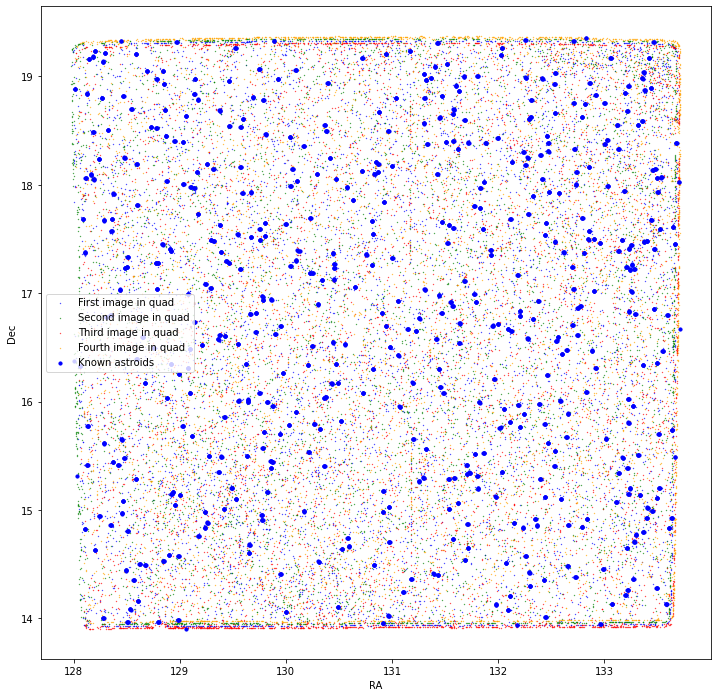

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(12,12))

axs.scatter(singles_1['RA'], singles_1['Dec'], c='blue', s=0.1, label='First image in quad')
axs.scatter(singles_2['RA'], singles_2['Dec'], c='green', s=0.1, label='Second image in quad')
axs.scatter(singles_3['RA'], singles_3['Dec'], c='red', s=0.1, label='Third image in quad')
axs.scatter(singles_4['RA'], singles_4['Dec'], c='orange', s=0.1, label='Fourth image in quad')
axs.scatter(quad1_labels['RA_DEG'], quad1_labels['DEC_DEG'], c='blue', s=10, label='Known astroids')
axs.legend()
axs.set_xlabel('RA')
axs.set_ylabel('Dec')

Text(0, 0.5, 'Dec')

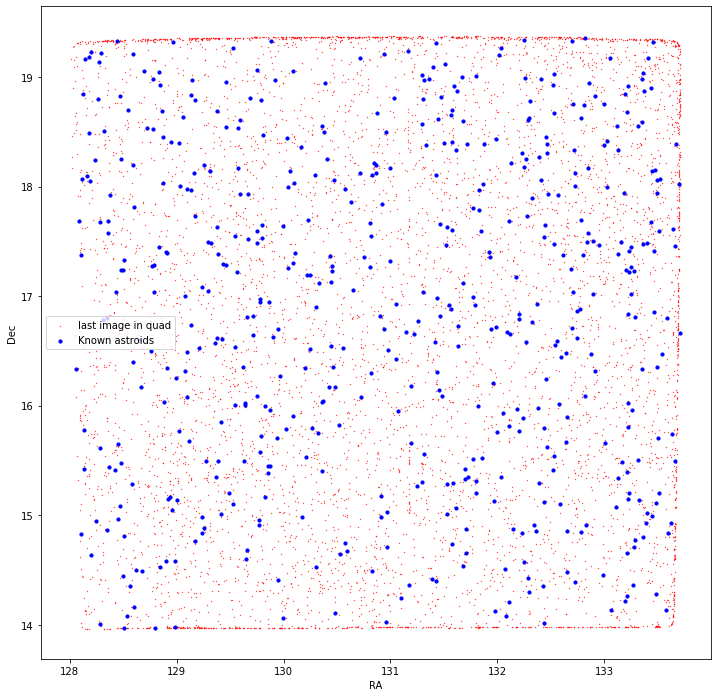

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(12,12))

axs.scatter(singles_4['RA'], singles_4['Dec'], c='red', s=0.1, label='last image in quad')
axs.scatter(labels4['RA_DEG'], labels4['DEC_DEG'], c='blue', s=10, label='Known astroids')
axs.legend()
axs.set_xlabel('RA')
axs.set_ylabel('Dec')

#### We have to transpose X and Y coordinates, because the x-y coordinates used in the .kastx files has 0,0 in lower left. 

#### However, the arrays are indexed to upper left corner. This translation allows us to visualize the actual asteroid.

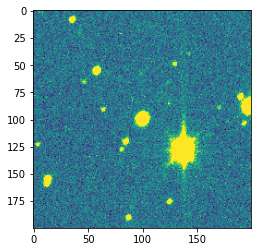

In [47]:
# the first asteroid identified in the last (index 11) .kastx file is centered on these coordinates
tpx = 9411
tpy = 10221
pad = 100
atlasimg = fits.open(image_filenames[11])['image'].data

plt.imshow(atlasimg[tpy-pad:tpy+pad,tpx-pad:tpx+pad], vmin=150, vmax=250)